<a href="https://colab.research.google.com/github/michelucci/TensorFlow20-Notes/blob/master/basics/Eager_Execution_basics_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eager execution basics - few various notes

Author and (C): Umberto Michelucci (umberto.michelucci@toelt.ai)

This is a notebook that covers some basics of eager execution and how to use TF2.0 for very basic tasks.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x  
except Exception:
  pass
import tensorflow as tf


TensorFlow 2.x selected.


Consider any operation that in TensorFlow 1.X would have needed a `session`, in 2.X this is not necessary and the simple direct evaluation happens.

In [0]:
x = tf.constant(3)
y = x + 3
print(y)

tf.Tensor(6, shape=(), dtype=int32)


Consider the following function, in which we calcualte the factorial of a number with TensorFlow tensors.

In [0]:
def factorial(n):
  fact = tf.constant(1)
  n = tf.convert_to_tensor(n)
  for num in range(1, n.numpy()+1):
    fact = fact * num

  print (fact)

You can simply run it and get the results you want, without the need of creating a session.

In [0]:
factorial(3)

tf.Tensor(6, shape=(), dtype=int32)


In [0]:
factorial(4)

tf.Tensor(24, shape=(), dtype=int32)


# MNIST Example

In [0]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

11493376/11490434 [==============================] - 0s 0us/step


We define a dumb sequential model.

In [0]:
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

In [0]:
for images,labels in dataset.take(1):
  print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[-0.07004383 -0.04109984 -0.05877591 -0.01022927 -0.04516312 -0.01131148
   0.03299733 -0.01285523  0.05138505 -0.03488974]]


Then optimizer and loss

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

Finally the `train_step()` that will perform the weight update each time is called. This step will be called each epoch during the training loop.

In [0]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)
    
    # Add asserts to check the shape of the output.
    tf.debugging.assert_equal(logits.shape, (32, 10))
    
    loss_value = loss_object(labels, logits)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, mnist_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [0]:
def train():
  for epoch in range(3):
    for (batch, (images, labels)) in enumerate(dataset):
      train_step(images, labels)
    print ('Epoch {} finished'.format(epoch))

In [0]:
train()

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished


Text(0, 0.5, 'Loss [entropy]')

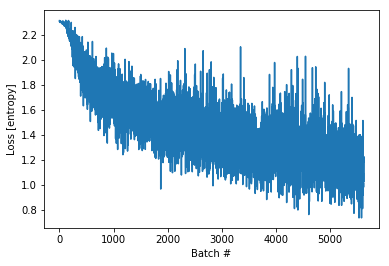

In [0]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')